## Bra and Ket Definitions

$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\,\right|}$$

In [ ]:
import numpy as np
import functools as ft
from sympy import Matrix, init_printing
init_printing()

In [ ]:
import sys
sys.path.append('../')
from tensornetworks.tensornetworks import contract_indices

# Triangulo de Heisenberg

Sistema de 3 spines $\frac{1}{2}$ con un Hamiltoniano:

$$H = J (\vec{S}_1\vec{S}_2 + \vec{S}_1\vec{S}_3 + \vec{S}_2\vec{S}_3)$$

## 1. Spinores

Como vimos en el notebook anterior tenemos el sistema de spines y la defincion del Spinor

$$\vec{S} = 
\begin{pmatrix}
    S_+/\sqrt{2} \\
    S_z \\
    S_-/\sqrt{2} \\
\end{pmatrix}
$$

En este caso el producto tensorial lo podríamos poner como una suerte de producto escalar:


$$
\vec{S}_1^T \vec{S}_2 = 
\begin{pmatrix}
    S_-^1/\sqrt{2}  & S^1_{z} & S^1 _+/\sqrt{2} \\
\end{pmatrix}
\begin{pmatrix}
    S^2_+/\sqrt{2} \\
    S^2_z \\
    S^2_-/\sqrt{2} \\
\end{pmatrix}= \\
=\frac{S^1_{-} \otimes S^1_+}{2} + S^1_z \otimes S^2_z + \frac{S^1_+ \otimes S^2_-}{2}=
S^1_x \otimes S^2_x + S^1_y \otimes S^2_y + S^1_z\otimes S^2_z
$$

In [ ]:
S_z = 0.5 *  np.array([[1, 0], [0, -1]])
S_plus = np.array([[0, 1.0/np.sqrt(2)], [0 ,0]] )
S_less = S_plus.T
t_spinor = np.array([S_plus, S_z, S_plus.T])
# Quiero shape (2, 2, 3)
t_spinor = t_spinor.transpose(1, 2, 0)

## 2. Contraccion de Spinores

Queremos calcular el Hamiltoniano del triángulo de Heisenberg haciendo la contracción del tensor networ que representa dichoe triángulo. En el noteboook anterior lo intentamos haciendo las contracciones puras del tensores de spinor con el de identidad pero como vimos las contracciones se complicaban y obtener el Hamiltoniano requería muchas correcciones en las dimensiones de los tensores resultantes. 

Para resolver esto hay que pensar primero en que consiste la representación matricial de un Hamiltoniano. Sea $H$ un hamiltoniano y sea $\{\ket{\alpha}\}$ una base en el espacio de Hilbert del Hamiltoniano, esto es: si $\ket{\Psi}$ es un estado valido del espacio de Hilbert donde actúa $H$ entonces:

$$\ket{\Psi} = b_{\alpha} \ket{\alpha}$$

Donde usamos el convenio de sumación de Einstein.

La representación matricial del Hamiltoniano $H$ en la base $\{\ket{\alpha}\}$ no será más que:

$$\bra{\beta} H \ket{\alpha}$$

Donde $\bra{\beta}$ sería la base $\{\ket{\alpha}\}$ en el espacio dúal (es decir como bras en vez de kets). 

Con esto en mente podemos, por ejemplo, dibujar el tensor network correspondiente a la matriz del elemento $\vec{S}_1\vec{S}_2$ del Hamiltoniano de Heisenberg

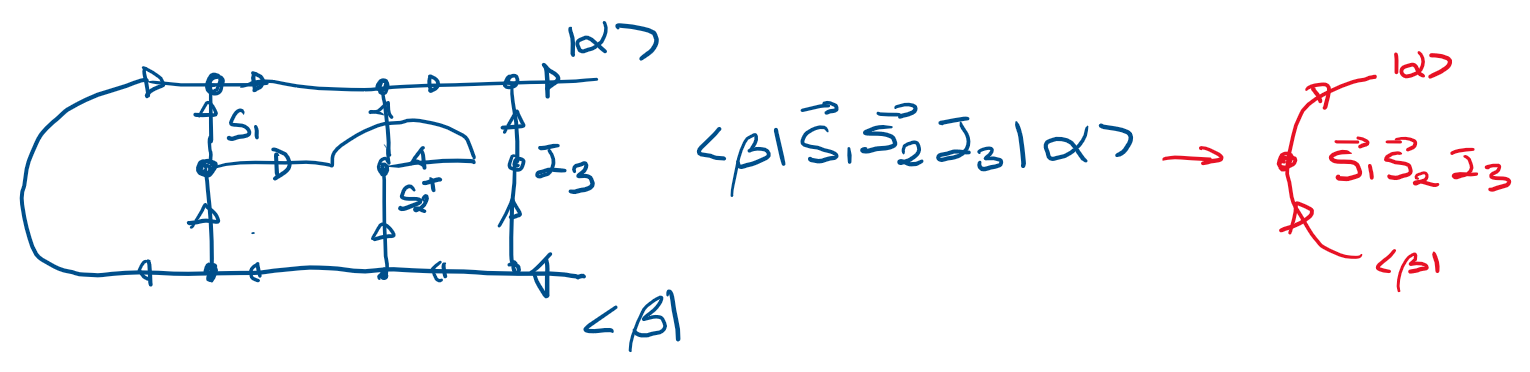

Hay que tener en cuenta que el elemento $\vec{S}_1\vec{S}_2$ realmente debería ser $\vec{S}_1\vec{S}_2I_3$ pero las identidades no las tendremos en cuenta para simplificar la notación

En el siguiente dibujo despiezamos las contracciones sitio a sitio para ver como funciona el diagrama:

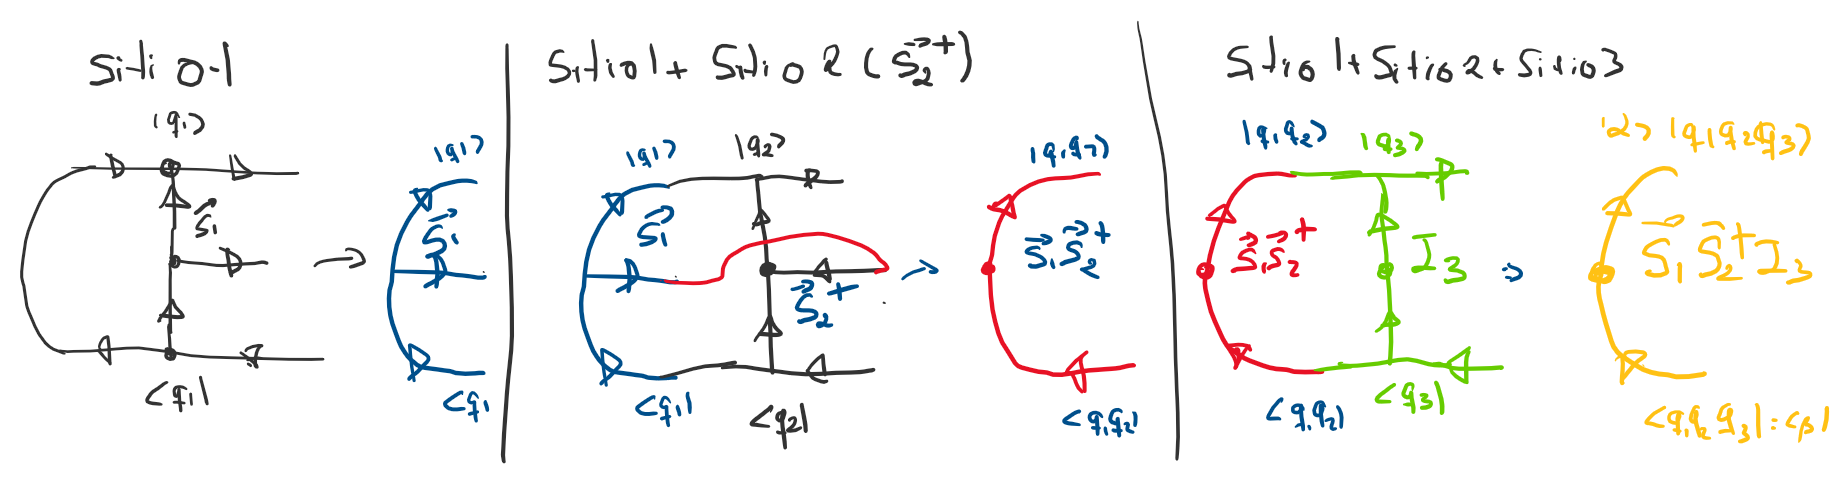

En este caso es como si descompusiésemos el Hamiltoniano en operadores que solo afectan a un sistio del tríangulo (tambien puede ser una cadena), y estos opearores solo van a poder ser tensores de rank 2 ó 3. Además si empezamos por la izquierda y contraemos los dos primeros sitios vemos que podemos colapsar todo a un tensor único de rank 2 ó 3 y que dicho tensor tendría la acción de los sitios 1 y 2. Este tensor se podría contraer con el operador que se aplica en el siguiente sitio y así sucesivamente. Cada vez que añadimos un sition siempre obtdremos un tensor de rank 2 o 3 **PERO las patas físicas del tensor tendrán una dimensión mayor!!** Esto se ve en la segunda parte de la figura donde los sitios 1 y 2 ya se han contraido a un tensor de rank 2 pero las patas físicas tienen unproducto tensorial de los kets (y los bras correspondientes) de los dos sitios:

Sitio 1: $\ket{q_1}$. Sitio 2: $\ket{q_2}$. Sitio 1+2: $\ket{q_1q_2} = \ket{q_1} \otimes \ket{q_2}$
Sitio 3: $\ket{q_2}$. Sitio 1+2+3: $\ket{q_1q_2q_3}$

Así pues podríamos recorrer el tensor network usando una función que tome dos operadores actuando sobre cada sitio y lo convertimos a un tensor de rank 2 ó 3 que represente la actuación sobre dos sitios. Para añadir el tercer sitio solo tendremos que usar la misma función con el tensor resultante y el operador que se aplique sobre el nuevo sitio y así sucesivamente.



#### Rank 3 identity tensor

La función que creemos necesita actualizar las dimensiones de su tensor saliente teniendo en cuenta las dimensiones de sus tensores entrantes. Para ello tenemos que poder crear un tensor identidad qe sea capaz de componer ambas dimensiones tal y como se ve en la imagen

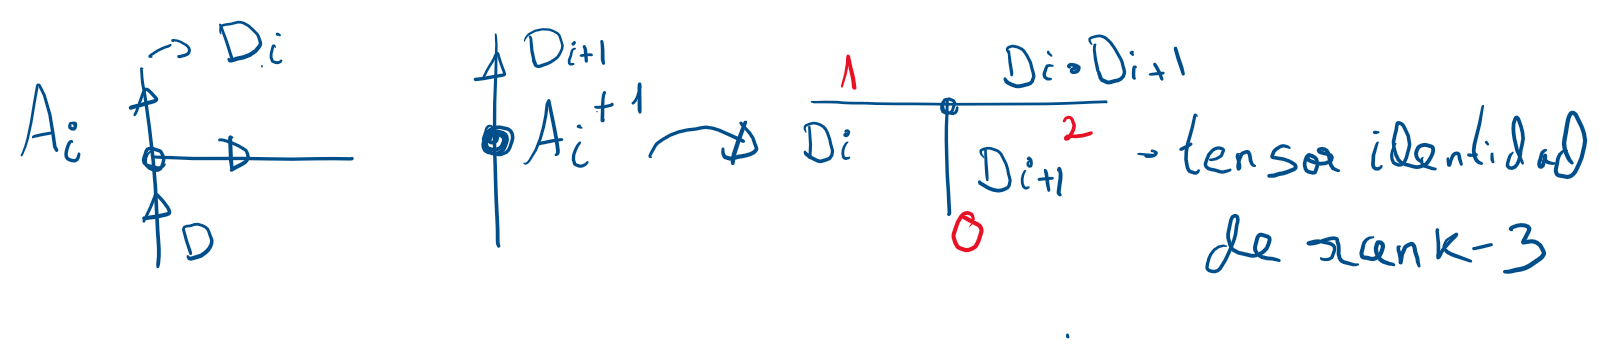

La numeración en rojo corresponde al shape del tensor de salida

In [ ]:
def tensor_identity(dim_1, dim_2):
    """
    Given 2 input dimensions creates the rank 3 identity tensor that allow to combine them:

    (input_dimension, phyiscal_dimension, input_dimension * phyiscal_dimension)
    """
    
    m_i = np.identity(dim_1 * dim_2)
    t_i = m_i.reshape(dim_2 , dim_1, dim_1 * dim_2)
    return t_i

La función deseada tendrá dos entradas que corresponderá a dos tensores y los compodrá generando un tensor de salida. Vamos a trabajar con tensores de rank 2 y 3 por lo que las posibles combinaciones de entrada salida serán:

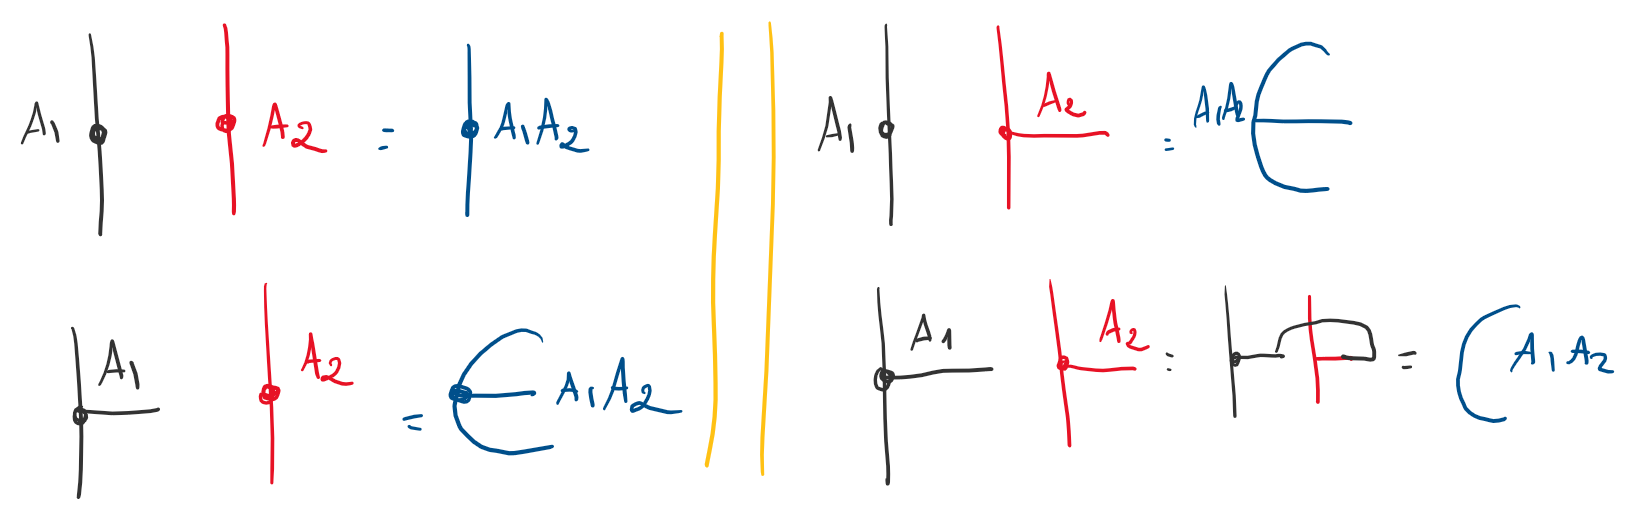

In [ ]:
def braket(before, now):# operator, bra):
    
    rank_before = before.ndim
    rank_now = now.ndim
    
    
    if before.shape[0] != before.shape[1]:
        raise ValueError("Problem with before shapes")
    if now.shape[0] != now.shape[1]:
        raise ValueError("Problem with now shapes")        
    
    # Create 3-rank identity using before tensor
    ket = tensor_identity(before.shape[0], now.shape[0])
    bra = ket#.transpose(1,0,2)
    
    if (rank_before == 2) and (rank_now == 2):
        # Case 0
        step = contract_indices(before, ket, [1], [1])
        step = contract_indices(step, now, [1], [1])
        step = contract_indices(step, bra, [0,2], [1, 0])
        if step.ndim != 2:
            text = "Case 0: final tensor dimension is: {} but should be 2".format(step.ndim)
            raise ValueError(text)
        step = step.transpose(1, 0)
    
    elif (rank_before == 2) and (rank_now == 3):
        # Case 1
        step = contract_indices(before, ket, [1], [1])
        step = contract_indices(step, now, [1], [1])
        step = contract_indices(step, bra, [0,2], [1, 0])
        if step.ndim != 3:
            text = "Case 2: final tensor dimension is: {} but should be 3".format(step.ndim)
            raise ValueError(text)
        step = step.transpose(2, 0, 1)               

    elif (rank_before == 3) and (rank_now == 2):
        # Case 2
        step = contract_indices(before, ket, [1], [1])
        step = contract_indices(step, now, [2], [1])
        step = contract_indices(step, bra, [0, 3], [1, 0])
        if step.ndim != 3:
            text = "Case 2: final tensor dimension is: {} but should be 3".format(step.ndim)
            raise ValueError(text)
        step = step.transpose(2, 1, 0)   

    elif (rank_before == 3) and (rank_now == 3):
        # Case 3
        step = contract_indices(before, ket, [1], [1])
        step = contract_indices(step, now, [1, 2], [2, 1])
        step = contract_indices(step, bra, [0, 2], [1, 0])
        if step.ndim != 2:
            text = "Case 3: final tensor dimension is: {} but should be 2".format(step.ndim)
            raise ValueError(text)
        step = step.transpose(1, 0)
    else:
        raise ValueError("Problem with input shapes")

    return step
    

### Caso 0

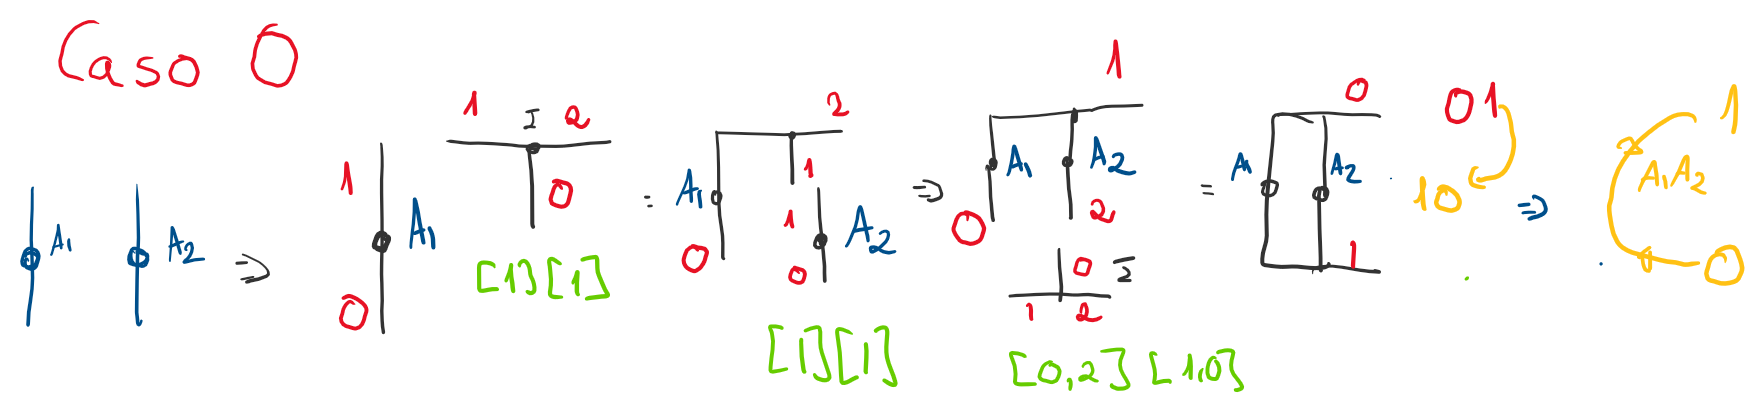

En rojo se ve el tracking de las shape de los tensores en todo momento. En verde se pintan las contracciones que se van a realizar en cada paso. En el ultimo paso los ínidces en naranja indican la trasposición de índices que se debe aplicar al tensor para que el shape sea compatible.

In [ ]:
final = braket(np.identity(2), np.identity(2))

### Caso 1

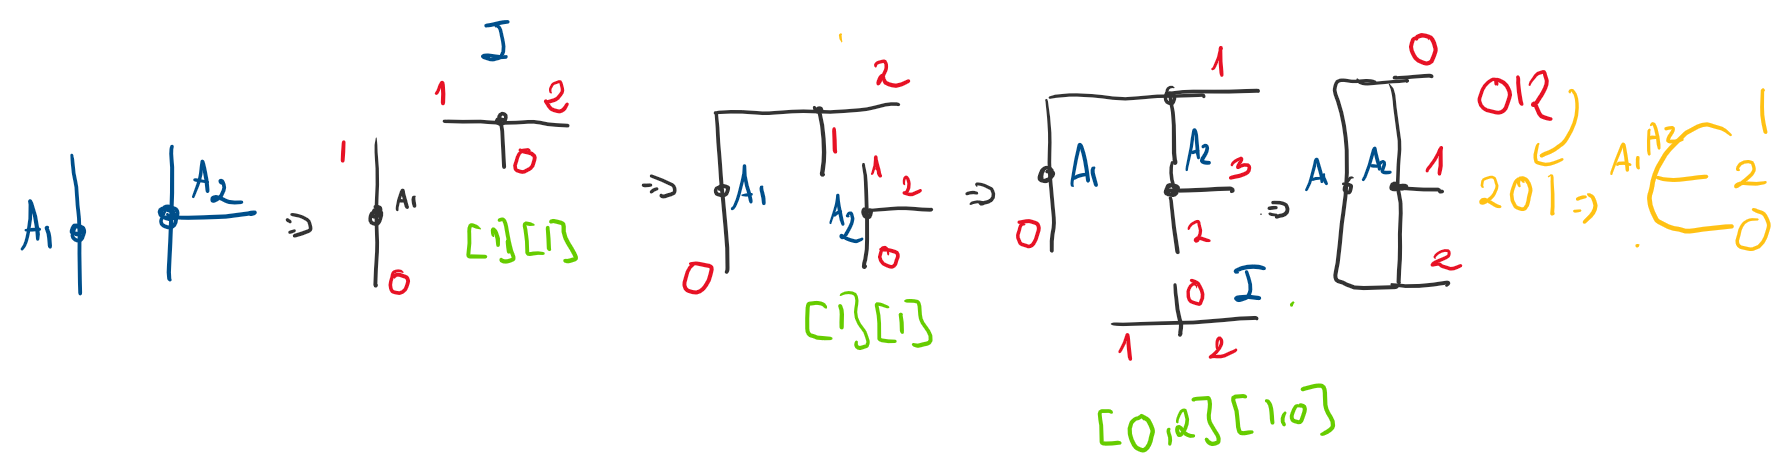

En rojo se ve el tracking de las shape de los tensores en todo momento. En verde se pintan las contracciones que se van a realizar en cada paso. En el ultimo paso los ínidces en naranja indican la trasposición de índices que se debe aplicar al tensor para que el shape sea compatible.

In [ ]:
final = braket(np.identity(2), t_spinor)

In [ ]:
final.shape

### Caso 2

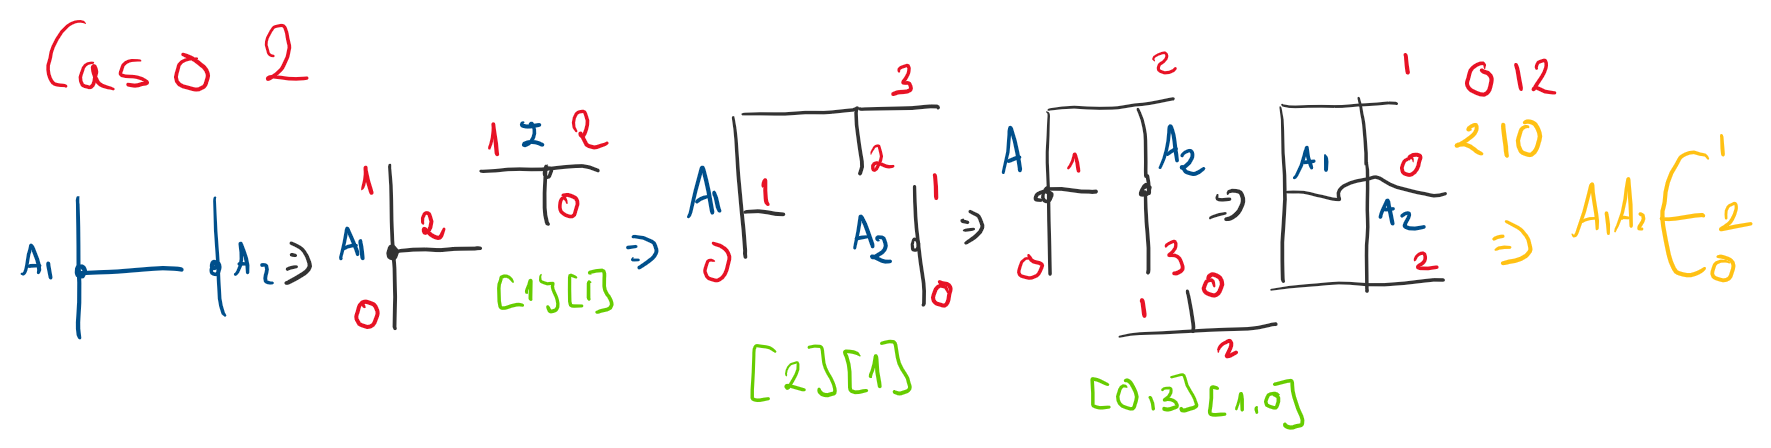

En rojo se ve el tracking de las shape de los tensores en todo momento. En verde se pintan las contracciones que se van a realizar en cada paso. En el ultimo paso los ínidces en naranja indican la trasposición de índices que se debe aplicar al tensor para que el shape sea compatible.

In [ ]:
final = braket(t_spinor, np.identity(2))

In [ ]:
final.shape

### Caso 3

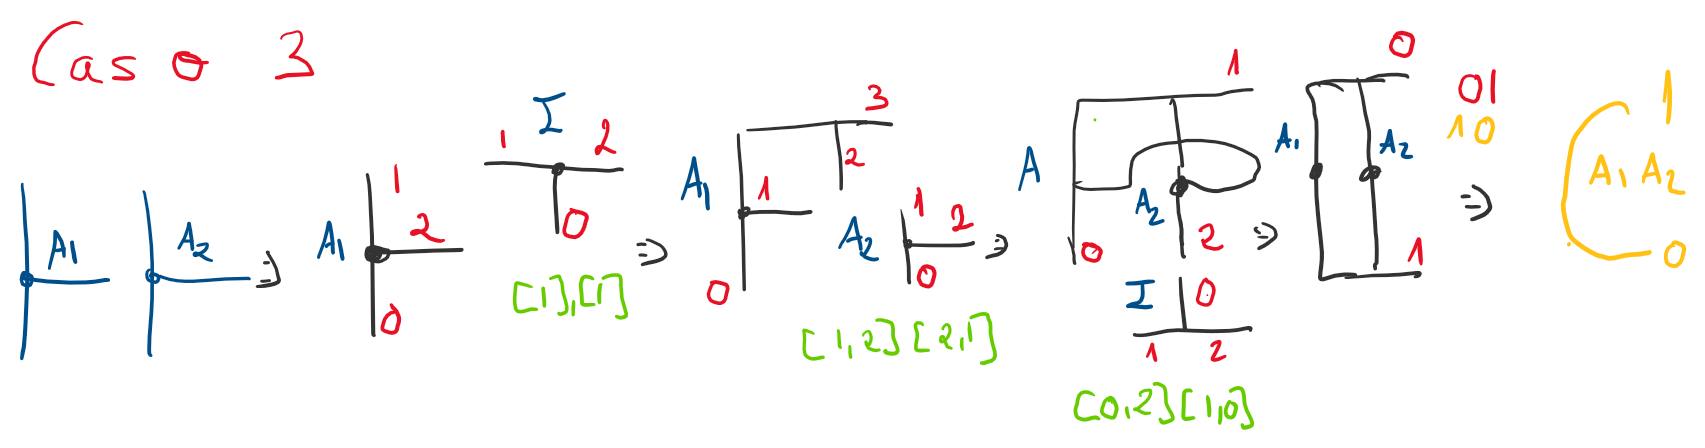

En rojo se ve el tracking de las shape de los tensores en todo momento. En verde se pintan las contracciones que se van a realizar en cada paso. En el ultimo paso los ínidces en naranja indican la trasposición de índices que se debe aplicar al tensor para que el shape sea compatible.

In [ ]:
final = braket(t_spinor, t_spinor)#, 2)

In [ ]:
final = braket(final, np.identity(2))

## Zipper

Las contracciones del tensor network la haremos de izquierda a derecha de dos en dos de tal modo que la salida de la contracción de dos sitios se utilizara como la primera entrada de la contracción con el sitio siguiente

In [ ]:
def zipper(sites_list):
    step = braket(sites_list[0], sites_list[1])
    rest_of_sites = sites_list[2:]
    for site in rest_of_sites:
        step = braket(step, site)
    return step

Descomposición del Hamiltoniano en una cadena de sitios donde en cada uno actúa el tensor correspondiente

## Testing implementation in script

In [ ]:
s1s2 = [t_spinor, t_spinor.transpose(1, 0, 2), np.identity(2)]
s1s3 = [t_spinor, np.identity(2), t_spinor.transpose(1, 0, 2)]
s2s3 = [np.identity(2), t_spinor, t_spinor.transpose(1, 0, 2)]

In [ ]:
from tensornetworks.tensornetworks import zipper, mps_contracion

In [ ]:
# Calulamos el Hamiltoniano
h = zipper(s1s2) + zipper(s1s3) + zipper(s2s3)

In [ ]:
#Autovalores
np.linalg.eigvalsh(h)

In [ ]:
%%time
I = np.identity(2)
S1S2 = np.kron(S_less, S_plus) + np.kron(S_z, S_z) + np.kron(S_plus, S_less)
S1S2I3 = np.kron(S1S2, I)

In [ ]:
S1S2

In [ ]:
%%time
mps_contracion(t_spinor, t_spinor.transpose(1, 0, 2))